In [115]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft
import pandas as pd
import seaborn as sns
import networkx as nx

In [116]:
def split_data_ranges(start, end, num_parts):
    total_rows = end - start + 1
    rows_per_part = total_rows // num_parts
    remaining_rows = total_rows % num_parts

    ranges = []
    current_row = start
    for i in range(num_parts):
        part_size = rows_per_part + (1 if i < remaining_rows else 0)
        part_end = current_row + part_size - 1
        ranges.append((current_row, part_end))
        current_row = part_end + 1

    return ranges

In [117]:
original_brain_signal = pd.read_csv('233.csv')

for i in range(0, 3):
    original_brain_signal = original_brain_signal.drop(original_brain_signal.columns[0], axis=1)


In [118]:
ranges = []

ranges.extend(split_data_ranges(23588, 28587, 2))

ranges.extend(split_data_ranges(28588, 44167, 10))

ranges.extend(split_data_ranges(44168, 49167, 2))

In [119]:
original_heatmaps = []

In [120]:
for i, (start, end) in enumerate(ranges, start=1):
    df_part = original_brain_signal.iloc[start:end+1]
    original_heatmaps.append(df_part)
    # plt.figure(figsize=(10, 6))
    # sns.heatmap(df_part.T)  # Transpose data for correct orientation
    # plt.title('Time Series Heatmap')
    # plt.xlabel('Time Step')
    # plt.ylabel('Channel')
    # plt.show()

C:\Users\laksh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


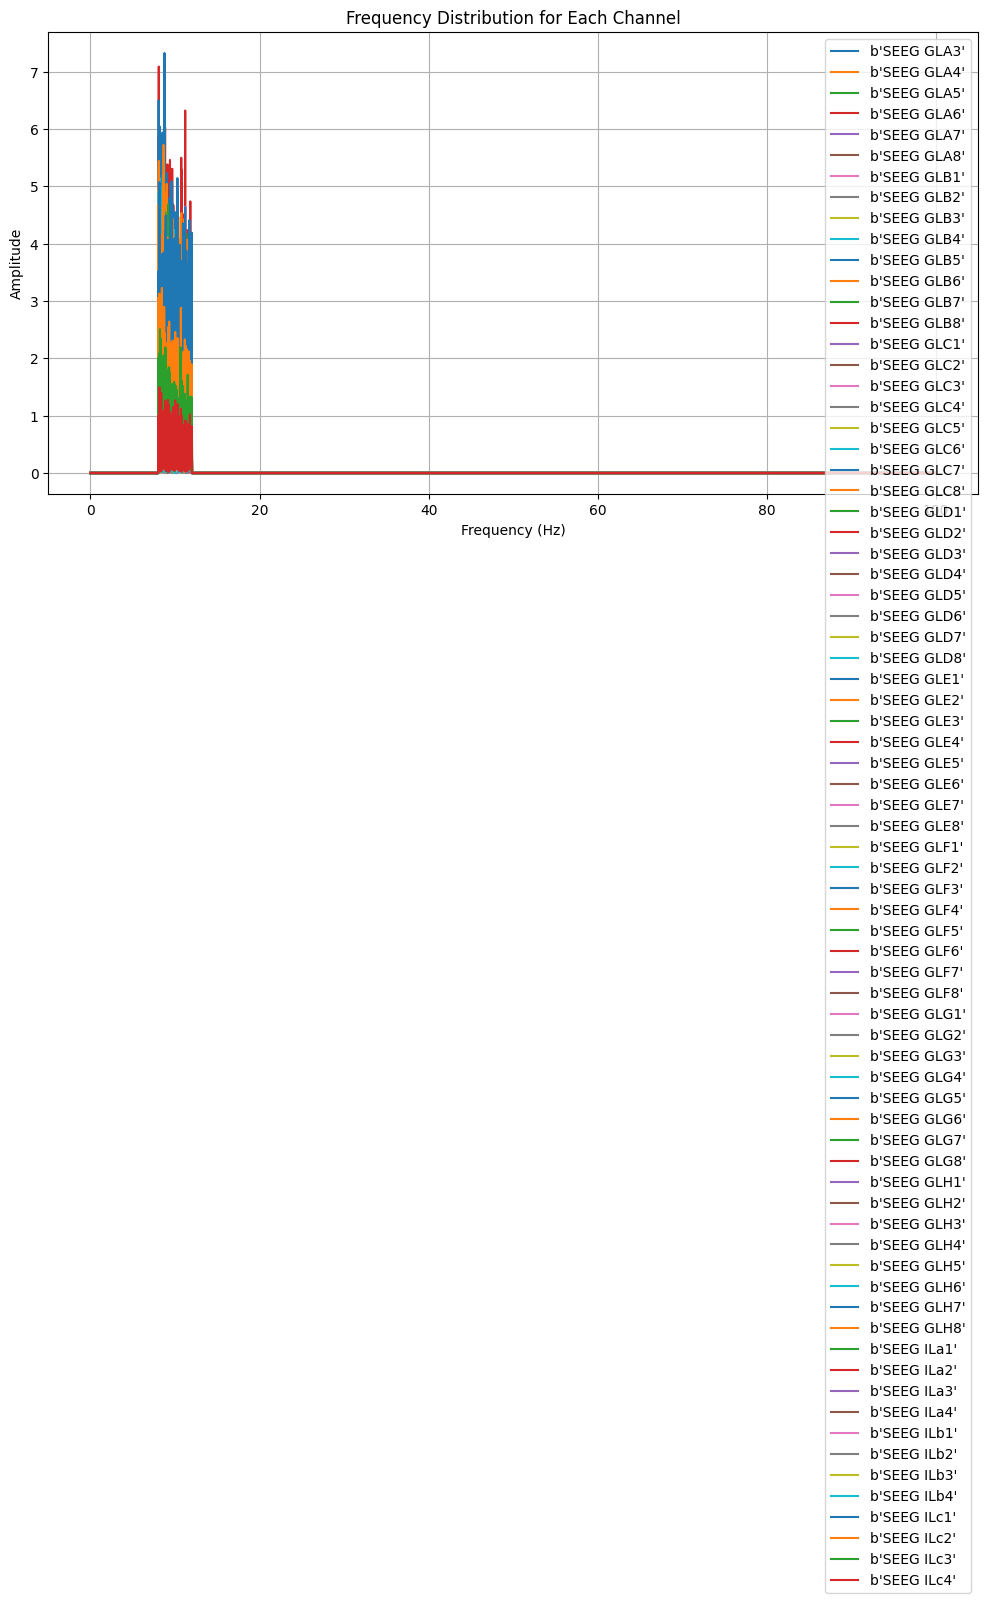

In [34]:


# copy data to df
df = original_brain_signal.copy()

# Get the column names
column_names = original_brain_signal.columns

# Compute the Fourier transform for each channel
sampling_rate = 200  # Assuming a sampling rate of 1000 Hz
n = len(original_brain_signal)
freq = np.fft.fftfreq(n, d=1/sampling_rate)

plt.figure(figsize=(12, 6))
for column in column_names:
    channel_data = original_brain_signal[column].values
    yf = fft(channel_data)

    # band pass filter 8hz to 12 hz
    yf[(freq < 8)] = 0
    yf[(freq > 12)] = 0
    amplitude = 2/n * np.abs(yf[:n//2])
    plt.plot(freq[:n//2], amplitude, label=column)

    # take inverse of yf
    y_inv = np.fft.ifft(yf)
    
    # conctenate real part of y_inv for each channel into updated data
    df[column] = y_inv.real
    
plt.title('Frequency Distribution for Each Channel')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

In [121]:
filtered_brain_signal = []

for i, (start, end) in enumerate(ranges, start=1):
    df_part = df.iloc[start:end+1]
    filtered_brain_signal.append(df_part)
    # plt.figure(figsize=(10, 6))
    # sns.heatmap(df_part.T)  # Transpose data for correct orientation
    # plt.title('Time Series Heatmap')
    # plt.xlabel('Time Step')
    # plt.ylabel('Channel')
    # plt.show()

In [ ]:
for i, (start, end) in enumerate(ranges, start=1):
    # plot original and filtered data as heatmap with subplots
    plt.figure(figsize=(10, 6))
    plt.subplot(14, 2, i+1)
    sns.heatmap(original_heatmaps[i-1].T)  # Transpose data for correct orientation
    plt.title('Original Time Series Heatmap')
    plt.xlabel('Time Step')
    plt.ylabel('Channel')
    plt.subplot(14, 2, 2+(i+1))
    sns.heatmap(filtered_brain_signal[i-1].T)  # Transpose data for correct orientation
    plt.title('Filtered Time Series Heatmap')
    plt.xlabel('Time Step')
    plt.ylabel('Channel')
    plt.show()

In [36]:
# store df into csv
df.to_csv('233_filtered.csv')

In [59]:
def apply_gcc_threshold(matrix, alpha):
    binarized_matrix = matrix.copy()
    
    np.fill_diagonal(binarized_matrix.values, 0)
    upper_triangle = np.triu(binarized_matrix, k=1).flatten()
    
    sorted_upper_triangle = np.sort(upper_triangle)[::-1]
    
    num_elements = len(sorted_upper_triangle)
    gcc_index = int(alpha * num_elements)
    
    threshold_value = sorted_upper_triangle[gcc_index]
    
    binarized_matrix = binarized_matrix.applymap(lambda x: 1 if x >= threshold_value else 0)
    
    return binarized_matrix

In [150]:
def draw_graph(matrix, title, im_name, im_size):
    # plot graph and save as image
    G = nx.from_pandas_adjacency(matrix)
    plt.figure(figsize=(im_size, im_size))
    nx.draw(G, with_labels=False, node_size=150, node_color='red', font_size=10, font_color='black', edge_color='black', linewidths=1, font_weight='bold')
    plt.title(title, fontsize=80)
    plt.axis('off')
    plt.savefig(im_name + '.png')
    plt.show()

In [ ]:
truncated_data_df = pd.read_csv('233_filtered.csv')
correlation_matrix = truncated_data_df.corr()

binarized_correlation_matrix = apply_gcc_threshold(correlation_matrix, alpha=0.4743)
# alpha = 0.4743

title = 'GCC Thresholded Brain Connectivity Graph'
im_name = 'GCC_Thresholded_Brain_Connectivity_Graph'

draw_graph(binarized_correlation_matrix, title, im_name, im_size=50)

In [ ]:
num_groups = len(original_brain_signal)

for i, (start, end) in enumerate(ranges, start=1):
    df_part = original_brain_signal.iloc[start:end+1]
    correlation_matrix = df_part.corr()
    binarized_correlation_matrix = apply_gcc_threshold(correlation_matrix, alpha=0.4743)
    title = 'GCC Thresholded Brain Connectivity Graph for Group ' + str(i)
    draw_graph(binarized_correlation_matrix, title, im_size=50)

In [ ]:
num_groups = len(filtered_brain_signal)

for i, (start, end) in enumerate(ranges, start=1):
    df_part = df.iloc[start:end+1]
    correlation_matrix = df_part.corr()
    binarized_correlation_matrix = apply_gcc_threshold(correlation_matrix, alpha=0.4743)
    title = 'GCC Thresholded Brain Connectivity Graph for Group ' + str(i)
    im_name = 'thresholded_graph/filtered_group_' + str(i)
    draw_graph(binarized_correlation_matrix, title, im_name, im_size=50)

In [111]:
# Read the truncated time series data from the CSV file
truncated_data_df = pd.read_csv('233_filtered.csv')

# Compute the correlation matrix
correlation_matrix = truncated_data_df.corr()

# Function to binarize the correlation matrix using GCC
def binarize_with_gcc(correlation_matrix):
    # Create a graph from the correlation matrix
    G = nx.from_numpy_array(np.abs(correlation_matrix.values))
    
    # Find the Giant Connected Component
    gcc_nodes = max(nx.connected_components(G), key=len)
    
    # Create a subgraph containing only the GCC nodes
    gcc_subgraph = G.subgraph(gcc_nodes)
    
    # Convert the subgraph to a binary adjacency matrix
    binarized_adjacency_matrix = nx.adjacency_matrix(gcc_subgraph).todense()
    
    return binarized_adjacency_matrix

# Binarize the correlation matrix using GCC
binarized_correlation_matrix = binarize_with_gcc(correlation_matrix)

# Display the binarized correlation matrix
print("Binarized Correlation Matrix (GCC):")
print(binarized_correlation_matrix)

Binarized Correlation Matrix (GCC):
[[1.00000000e+00 1.37773798e-04 2.55567612e-04 ... 1.09697927e-04
  1.99013559e-05 5.40059257e-05]
 [1.37773798e-04 1.00000000e+00 3.28102380e-01 ... 7.57938135e-02
  1.31826595e-01 2.25137548e-01]
 [2.55567612e-04 3.28102380e-01 1.00000000e+00 ... 5.54151872e-02
  1.30510160e-01 2.36453595e-01]
 ...
 [1.09697927e-04 7.57938135e-02 5.54151872e-02 ... 1.00000000e+00
  4.07790308e-01 2.90214378e-01]
 [1.99013559e-05 1.31826595e-01 1.30510160e-01 ... 4.07790308e-01
  1.00000000e+00 4.96337826e-01]
 [5.40059257e-05 2.25137548e-01 2.36453595e-01 ... 2.90214378e-01
  4.96337826e-01 1.00000000e+00]]


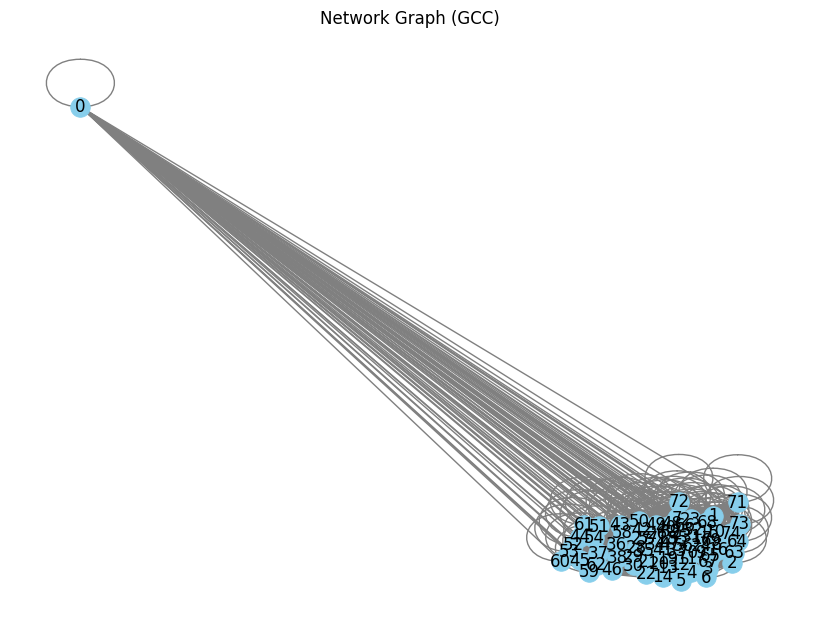

In [112]:
G = nx.from_numpy_array(binarized_correlation_matrix)

# Plot the network
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G)  # Layout algorithm for positioning nodes
nx.draw(G, pos, with_labels=True, node_size=200, node_color='skyblue', edge_color='gray', linewidths=0.5)
plt.title('Network Graph (GCC)')
plt.show()